# **Autoencoders for detecting anomalies in Electrocardiograms (ECGs)**

This is a development of an autoencoder model to detect anomalous Electrocardiograms (ECGs). We train the model for data points with normal rhythms and, then use that trained model to identify data points with abnormal behaviours with the use of reconstruction error of the model.

Dataset : [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model, losses, regularizers
import tensorflow as tf

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/DL prac


/content/drive/MyDrive/Colab Notebooks/DL prac


In [6]:
# merge train and test file into a single file called 'data.txt'
!cat ECG5000_TRAIN.txt ECG5000_TEST.txt > data.txt
df = pd.read_csv('data.txt', sep = '  ', header = None)

<ipython-input-6-92c6d6276259>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('data.txt', sep = '  ', header = None)


In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,-0.493223,-0.463052,-0.301644,-0.232734,-0.125055,-0.153943,-0.024357,-0.065609,0.034999,...,0.372167,0.337875,0.221405,0.273997,0.298664,0.263564,0.342564,0.419505,0.586607,0.860624,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,-0.206160,-0.224480,-0.048684,-0.019621,0.094805,0.116786,0.185186,0.230526,0.138027,...,0.222261,0.172847,0.150779,0.176566,0.280942,0.489939,0.660889,0.893193,1.026997,1.202394,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,-0.438023,-0.436248,-0.400114,-0.134987,-0.239347,-0.120244,-0.001971,0.285000,0.315646,...,0.459127,0.403937,0.298191,0.461101,0.664659,0.587757,0.701325,0.917205,1.247987,1.505568,1.640105,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,-0.653949,-0.566916,-0.524045,-0.414711,-0.387787,-0.284437,-0.072745,-0.160125,-0.092160,...,0.414661,0.371639,0.445170,0.484170,0.556061,0.658724,0.861158,1.016397,1.135606,1.216973,1.553079,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425

In [ ]:
df.shape

(5000, 141)

In [8]:
# add prefix to ease of access columns
df = df.add_prefix('a')
print(df.columns)

Index(['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9',
       ...
       'a131', 'a132', 'a133', 'a134', 'a135', 'a136', 'a137', 'a138', 'a139',
       'a140'],
      dtype='object', length=141)


In [9]:
df.describe()

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,a43,a44,a45,a46,a47,a48,a49,...,a91,a92,a93,a94,a95,a96,a97,a98,a99,a100,a101,a102,a103,a104,a105,a106,a107,a108,a109,a110,a111,a112,a113,a114,a115,a116,a117,a118,a119,a120,a121,a122,a123,a124,a125,a126,a127,a128,a129,a130,a131,a132,a133,a134,a135,a136,a137,a138,a139,a140
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.527400,-0.262476,-1.649511,-2.492211,-3.119443,-3.167438,-2.866308,-2.273126,-1.798127,-1.410124,-0.936082,-0.586326,-0.434430,-0.337621,-0.258235,-0.184443,-0.120015,-0.070396,-0.041849,-0.037049,-0.041243,-0.048908,-0.060176,-0.070725,-0.085491,-0.101144,-0.116070,-0.134461,-0.155811,-0.177542,-0.200685,-0.224244,-0.246686,-0.271476,-0.290321,-0.304461,-0.315111,-0.316851,-0.313070,-0.303238,-0.287315,-0.261244,-0.227944,-0.190993,-0.150814,-0.108084,-0.069482,-0.035765,-0.008621,0.013246,...,0.440115,0.442589,0.450790,0.466075,0.495508,0.540780,0.602076,0.671297,0.750998,0.842444,0.946527,1.051337,1.138071,1.187551,1.201909,1.190866,1.154605,1.086347,0.986863,0.864419,0.720300,0.570000,0.428955,0.319734,0.242586,0.181059,0.134708,0.109781,0.093630,0.081028,0.065780,0.047326,0.025409,0.004531,-0.009790,-0.019087,-0.026208,-0.029561,0.000637,0.086588,0.146319,0.070973,-0.062914,-0.276206,-0.507667,-0.761043,-0.834741,-0.642263,-0.487242,-0.706008
std,0.760372,1.152369,1.445493,1.386409,1.302802,1.104382,0.906133,0.731627,0.623100,0.637149,0.657945,0.592049,0.493606,0.426206,0.393553,0.382488,0.386315,0.400830,0.415267,0.423797,0.429734,0.434976,0.441768,0.447727,0.454600,0.461603,0.472726,0.483574,0.492048,0.503468,0.516169,0.530030,0.543061,0.552285,0.560649,0.564906,0.566459,0.560789,0.548964,0.536229,0.517508,0.494600,0.469321,0.437137,0.402690,0.370530,0.339816,0.312688,0.290779,0.275701,...,0.243031,0.251540,0.260888,0.273504,0.285234,0.304211,0.332687,0.371989,0.411086,0.461256,0.520027,0.574633,0.614855,0.623050,0.608319,0.582721,0.553923,0.531272,0.507226,0.485600,0.483479,0.511334,0.546391,0.565580,0.571998,0.573798,0.584480,0.589680,0.591613,0.597117,0.603953,0.610288,0.619812,0.633101,0.649239,0.667657,0.680713,0.693871,0.751844,0.920052,1.171299,1.404842,1.646585,1.895134,2.059758,2.086218,2.056220,1.859296,1.830987,1.414465
min,1.000000,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,-4.040526,-3.724538,-3.264576,-3.222345,-3.263484,-3.219212,-3.202187,-3.147504,-3.459917,-4.102102,-4.311241,-4.099888,-3.614973,-3.822298,-3.795567,-3.690817,-3.542485,-3.631665,-3.587112,-3.452215,-4.074752,-4.137454,-4.059662,-3.626646,-2.829471,-3.585866,-4.003401,-3.900724,-3.325329,-3.911093,-4.862443,-4.710268,-4.238206,-4.247936,-3.892782,-3.135950,-3.0

In [10]:
# check for null values
df.isnull().values.any()

False

In [12]:
df['a0'].value_counts()

a0
1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: count, dtype: int64

**Preprocessing data**

label 1 is considered as normal data points and, rest of four categories are abnormal data points. Anomalous data label is set to 0.

In [78]:
# normal data
normal = df[df['a0']==1]
features_norm = normal.drop(['a0'], axis=1)
X_train, X_test, _ , _ = train_test_split(features_norm, normal['a0'], test_size=0.2, random_state=42)

# anomalous data
anomaly = df[df['a0']!=1]
anomaly.loc[:, 'a0'] = 0  # anomaly label set to 0
X_anomaly = anomaly.drop(['a0'], axis=1)

print("Normal data : ")
print("Train set", X_train.shape)
print("Test set", X_test.shape)

print("\nAnomolus data : ")
print(X_anomaly.shape)

Normal data : 
Train set (2335, 140)
Test set (584, 140)

Anomolus data : 
(2081, 140)


In [16]:
# scaling data
scaler = MinMaxScaler()

X_train_scaled = scaler.fit(X_train)
X_train = X_train_scaled.transform(X_train)

X_test_scaled = scaler.fit(X_test)
X_test = X_test_scaled.transform(X_test)

X_anomaly_scaled = scaler.fit(X_anomaly)
X_anom = X_anomaly_scaled.transform(X_anomaly)

**Visualization of sample points**

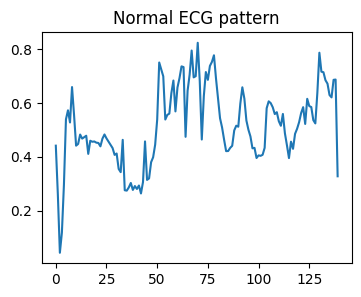

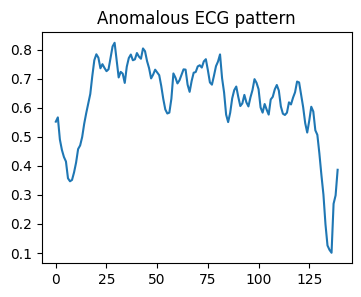

In [20]:
plt.figure(figsize=(4,3))
plt.plot(np.arange(140), X_train[0])
plt.title("Normal ECG pattern")
plt.show()

plt.figure(figsize=(4,3))
plt.plot(np.arange(140), X_anom[0])
plt.title("Anomalous ECG pattern")
plt.show()

**Model Development**

In [47]:
#----------- Define the model --------------
encoding_dim = 8
input_dim = X_train.shape[1]

# Encoder
input_img = Input(shape=(input_dim,))

x = Dense(32, activation='relu')(input_img)
x = Dense(16, activation='relu')(x)
encoded = Dense(encoding_dim, activation='relu')(x)

#Decoder
y = Dense(16, activation='relu')(encoded)
y = Dense(32, activation='relu')(y)
decoded = Dense(input_dim, activation='sigmoid')(y)

autoencoder = Model(input_img, decoded)

#----------- Compile the model --------------
autoencoder.compile(optimizer='adam', loss='mae')

In [48]:
#----------- Train the model --------------
history = autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/100
19/19 [==============================] - 1s 12ms/step - loss: 0.1228 - val_loss: 0.1545
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1032 - val_loss: 0.1322
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0804 - val_loss: 0.1201
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0702 - val_loss: 0.1187
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0664 - val_loss: 0.1167
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0635 - val_loss: 0.1132
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0601 - val_loss: 0.1103
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0574 - val_loss: 0.1081
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0555 - val_loss: 0.1070
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0530 - val_loss: 0.1052
Epoch 11

**Normal ECG - Original signal vs reconstructed signal**

73/73 [==============================] - 0s 1ms/step


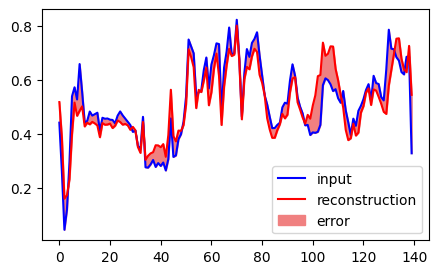

In [54]:
decoded_normal = autoencoder.predict(X_train)

plt.figure(figsize=(5,3))
plt.plot(X_train[0],'b')
plt.plot(decoded_normal[0],'r')
plt.fill_between(np.arange(140), decoded_normal[0], X_train[0], color='lightcoral' )
plt.legend(labels=["input", "reconstruction", "error"])
plt.show()

**Abnormal ECG - Original signal vs reconstructed signal**

66/66 [==============================] - 0s 4ms/step


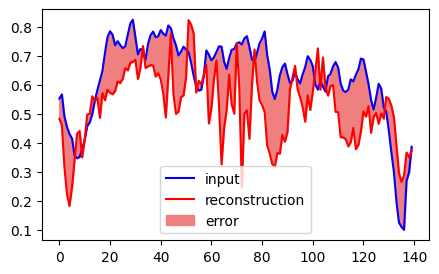

In [57]:
decoded_anomaly = autoencoder.predict(X_anom)

plt.figure(figsize=(5,3))
plt.plot(X_anom[0],'b')
plt.plot(decoded_anomaly[0],'r')
plt.fill_between(np.arange(140), decoded_anomaly[0], X_anom[0], color='lightcoral' )
plt.legend(labels=["input", "reconstruction", "error"])
plt.show()

**Detecting anomalies by setting the threshold of reconstruction error**

We have the traned the autoencoder for normal data in the way the reconstruction error is minimized. We consider that reconstruction error is high for anomolus data. Therefore, a data point is identified as a anomaly when the reconstruction error is higher than a fixed value.

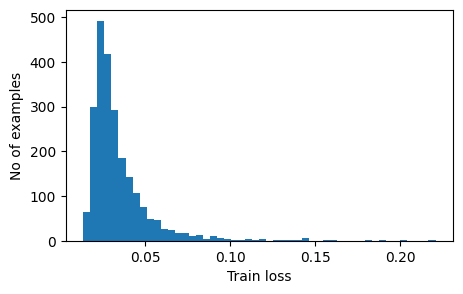

In [59]:
# error distribution of training data(normal data)
train_loss = losses.mae(decoded_normal, X_train)

plt.figure(figsize=(5,3))
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

There may be differnt methods to determine the threshod value. Here, we calculate the mean average error of normal examples in the training set. If a new data point's reconstruction error is significantly higher than what we typically see in normal cases, exceeding one standard deviation from the average error of the training set, we classify it as anomalous.

In [60]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.053199943849089666


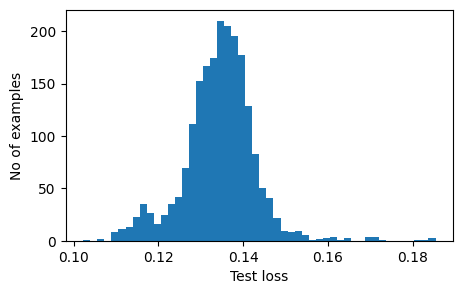

In [61]:
# check the error distribution for anomolus data
test_loss = losses.mae(decoded_anomaly, X_anom)

plt.figure(figsize=(5,3))
plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In above graph, we can see almost all data points have errors higher than the defined threshlod.

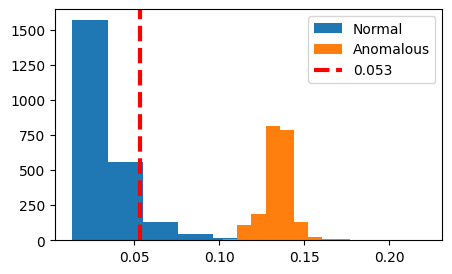

In [64]:
# Error distribution of normal and anomalies together
plt.figure(figsize=(5,3))
plt.hist(train_loss, bins = 10, label = 'Normal')
plt.hist(test_loss, bins = 10, label = 'Anomalous')
plt.axvline(threshold, color='r', linewidth = 3, linestyle = 'dashed', label = '{:0.3f}'.format(threshold))
plt.legend(loc = 'upper right')
plt.show()

In [65]:
test_loss.numpy()

array([0.13537666, 0.14651592, 0.13562819, ..., 0.131806  , 0.1396696 ,
       0.11688565])

In [68]:
# all anomalies have reconstruction error higher than threshold
anormalies_count = np.sum(test_loss.numpy() > threshold)
anormalies_count

2081

In [69]:
predicted_labels = tf.math.less(test_loss, threshold)

In [70]:
predicted_labels.numpy()

array([False, False, False, ..., False, False, False])

In [80]:
# here all anomalies are correctly detected. But we can adjust the threshlod values and adjust the precision and recall of model based on the usecase.
accuracy_score(anomaly['a0'], predicted_labels)

1.0